# DATA SCIENCE PROJECT E9
## KAGGLE - Stanford Ribonanza RNA Folding


In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

import platform
import tensorflow as tf
import pickle
import shutil
import gc
import math

In [2]:
# !pip install arnie

In [3]:
train = pd.read_parquet('train_data.parquet')
print(train.shape)
train.head()

(1643680, 419)


,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(train["signal_to_noise"].mean())

1.1943947


In [5]:

import tensorflow as tf
import pickle
import shutil
import gc
import math

In [6]:
policyConfig = 'float32'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

In [7]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except:
    strategy = tf.distribute.get_strategy()

In [8]:
tffiles_path = 'tfrfile'
tffiles = ['{}/{:03d}.tfrecord'.format(tffiles_path, idx) for idx  in range(164)]

In [9]:
def decode_tfrec(record_bytes):
    schema = {}
    schema["id"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["seq"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["dataset_name_2A3"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["dataset_name_DMS"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["reactivity_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    features = tf.io.parse_single_example(record_bytes, schema)

    sample_id = tf.sparse.to_dense(features["id"])
    seq = tf.sparse.to_dense(features["seq"])
    dataset_name_2A3 = tf.sparse.to_dense(features["dataset_name_2A3"])
    dataset_name_DMS = tf.sparse.to_dense(features["dataset_name_DMS"])
    reactivity_2A3 = tf.sparse.to_dense(features["reactivity_2A3"])
    reactivity_DMS = tf.sparse.to_dense(features["reactivity_DMS"])
    reactivity_error_2A3 = tf.sparse.to_dense(features["reactivity_error_2A3"])
    reactivity_error_DMS = tf.sparse.to_dense(features["reactivity_error_DMS"])

    out = {}
    out['seq']  = seq
    out['reactivity_2A3']  = reactivity_2A3
    out['reactivity_DMS']  = reactivity_DMS
    return out

In [10]:
def concat_target(x):
    reactivity_2A3 = x['reactivity_2A3']
    reactivity_DMS = x['reactivity_DMS']
    target = tf.concat([reactivity_2A3[..., tf.newaxis], reactivity_DMS[..., tf.newaxis]], axis = 1)
    target = tf.clip_by_value(target, 0, 1)
    return x['seq'], target

In [11]:
DEBUG = False # A boolean variable, to check if our model is in debugging mode
 
PAD_x = 0.0
PAD_y = np.nan
X_max_len = 206
batch_size = 256
val_batch_size = 512


if DEBUG:
    batch_size = 2
    val_batch_size = 2

num_vocab = 5
hidden_dim = 100

In [12]:
# https://www.kaggle.com/code/zulqarnainali/explained-transformer-tpu-inference/notebook
class transformer_block(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim//num_heads)
        self.ffn = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(feed_forward_dim, activation="relu"),
                tf.keras.layers.Dense(dim),
            ]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.supports_masking = True
        

    def call(self, inputs, training, mask):
        att_mask = tf.expand_dims(mask, axis=-1)
        att_mask = tf.repeat(att_mask, repeats=tf.shape(att_mask)[1], axis=-1)

        attn_output = self.att(inputs, inputs, attention_mask = att_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class positional_encoding_layer(tf.keras.layers.Layer):
    def __init__(self, num_vocab=5, maxlen=500, hidden_dim=384):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pos_emb = self.positional_encoding(maxlen-1, hidden_dim)
        self.supports_masking = True

    def call(self, x):
        x = tf.cast(x, dtype=tf.float32)  # Ensure input is cast to float32
        x = x * tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))
        maxlen = tf.shape(x)[-2]
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)))
        return x + self.pos_emb[:maxlen, :]

    def positional_encoding(self, maxlen, hidden_dim, ):
        depth = hidden_dim/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

In [13]:
def get_tfrec_dataset(tffiles, shuffle, batch_size, cache = False, calculate_sample_num = True, to_repeat = False):
    ds = tf.data.TFRecordDataset(
        tffiles, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)

    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(concat_target, tf.data.AUTOTUNE)

    if DEBUG:
        ds = ds.take(8)

    if cache:
        ds = ds.cache()

    samples_num = 0
    if calculate_sample_num:
        samples_num = ds.reduce(0, lambda x,_: x+1).numpy()        

    if shuffle:
        if shuffle == -1:
            ds = ds.shuffle(samples_num, reshuffle_each_iteration = True)
        else:
            ds = ds.shuffle(shuffle, reshuffle_each_iteration = True)

    if to_repeat:
        ds = ds.repeat()
    
    
    if batch_size:
        ds = ds.padded_batch(
            batch_size, padding_values=(PAD_x, PAD_y), padded_shapes=([X_max_len],[X_max_len, 2]), drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds, samples_num

In [14]:
val_len = 5
if DEBUG:
    val_len = 1

val_files = tffiles[:val_len]

if DEBUG:
    train_files = tffiles[val_len:val_len+1]
else:
    train_files = tffiles[val_len:]

In [15]:
print(train_files)

['tfrfile/005.tfrecord', 'tfrfile/006.tfrecord', 'tfrfile/007.tfrecord', 'tfrfile/008.tfrecord', 'tfrfile/009.tfrecord', 'tfrfile/010.tfrecord', 'tfrfile/011.tfrecord', 'tfrfile/012.tfrecord', 'tfrfile/013.tfrecord', 'tfrfile/014.tfrecord', 'tfrfile/015.tfrecord', 'tfrfile/016.tfrecord', 'tfrfile/017.tfrecord', 'tfrfile/018.tfrecord', 'tfrfile/019.tfrecord', 'tfrfile/020.tfrecord', 'tfrfile/021.tfrecord', 'tfrfile/022.tfrecord', 'tfrfile/023.tfrecord', 'tfrfile/024.tfrecord', 'tfrfile/025.tfrecord', 'tfrfile/026.tfrecord', 'tfrfile/027.tfrecord', 'tfrfile/028.tfrecord', 'tfrfile/029.tfrecord', 'tfrfile/030.tfrecord', 'tfrfile/031.tfrecord', 'tfrfile/032.tfrecord', 'tfrfile/033.tfrecord', 'tfrfile/034.tfrecord', 'tfrfile/035.tfrecord', 'tfrfile/036.tfrecord', 'tfrfile/037.tfrecord', 'tfrfile/038.tfrecord', 'tfrfile/039.tfrecord', 'tfrfile/040.tfrecord', 'tfrfile/041.tfrecord', 'tfrfile/042.tfrecord', 'tfrfile/043.tfrecord', 'tfrfile/044.tfrecord', 'tfrfile/045.tfrecord', 'tfrfile/046.tf

In [16]:
train_dataset, num_train = get_tfrec_dataset(train_files, shuffle = -1, batch_size = batch_size,
                                                  cache = True, calculate_sample_num = True,
                                            to_repeat = True)

val_dataset, num_val = get_tfrec_dataset(val_files, shuffle = False, batch_size = val_batch_size,
                                                  cache = True, calculate_sample_num = True)
print(num_train)
print(num_val)

162688
5120


In [17]:
batch = next(iter(val_dataset))
batch[0].shape, batch[1].shape

(TensorShape([512, 206]), TensorShape([512, 206, 2]))

In [18]:
# https://www.kaggle.com/code/zulqarnainali/explained-transformer-tpu-inference/notebook

def get_model(hidden_dim = 100, max_len = 206):
    inp = tf.keras.Input([None])
    x = inp

    x = tf.keras.layers.Embedding(num_vocab, hidden_dim, mask_zero=True)(x)
    x = positional_encoding_layer(num_vocab=num_vocab, maxlen=500, hidden_dim=hidden_dim)(x)

    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
    x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(2)(x)

    model = tf.keras.Model(inp, x)
    return model

In [19]:
def loss_fn(labels, targets):
    labels_mask = tf.math.is_nan(labels)
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    loss = tf.math.abs(labels - targets)
    loss = tf.where(labels_mask, tf.zeros_like(loss), loss)
    loss = tf.math.reduce_sum(loss)/mask_count
    return loss

In [20]:
gc.collect()

33

In [21]:
def get_model(hidden_dim = 300, max_len = 206):
    with strategy.scope():
        inp = tf.keras.Input([max_len])
        x = inp

        x = tf.keras.layers.Embedding(num_vocab, hidden_dim, mask_zero=True)(x)
        x = positional_encoding_layer(num_vocab=num_vocab, maxlen=500, hidden_dim=hidden_dim)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(2)(x)

        model = tf.keras.Model(inp, x)
        loss = loss_fn
        if platform.system() == "Darwin" and platform.processor() == "arm":
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
        else:
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        # optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005) # The non legacy AdamW runs slow on M2 (my computer)
        model.compile(loss=loss, optimizer=optimizer, steps_per_execution = 10)
        return model

tf.keras.backend.clear_session()

model = get_model(hidden_dim = 100,max_len = X_max_len)
model(batch[0])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 206)]             0         
                                                                 
 embedding (Embedding)       (None, 206, 100)          500       
                                                                 
 positional_encoding_layer   (None, 206, 100)          0         
 (positional_encoding_layer                                      
 )                                                               
                                                                 
 transformer_block (transfo  (None, 206, 100)          119688    
 rmer_block)                                                     
                                                                 
 transformer_block_1 (trans  (None, 206, 100)          119688    
 former_block)                                               

In [22]:
N_EPOCHS = 10
if DEBUG:
    N_EPOCHS = 5
N_WARMUP_EPOCHS = 0
LR_MAX = 5e-4
WD_RATIO = 0.05
WARMUP_METHOD = "exp"

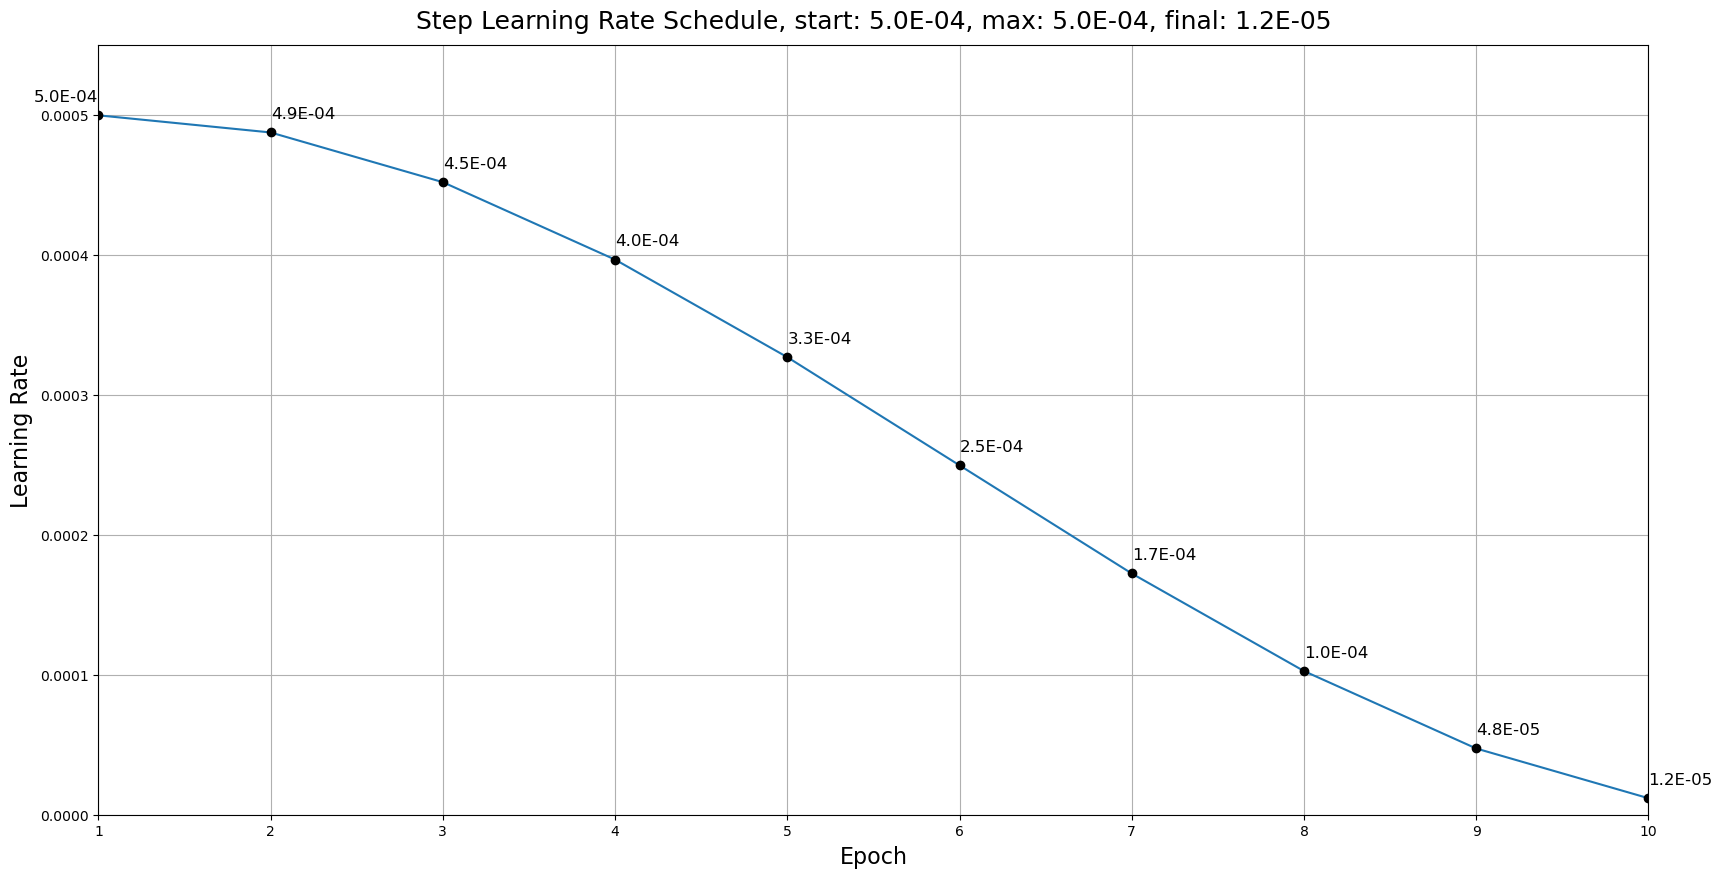

In [23]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [24]:
save_folder = 'model_weights'
try:
    os.mkdir(f'{save_folder}')
except:
    pass

class save_model_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch == 3 or (epoch+1)%25 == 0:
            self.model.save_weights(f"{save_folder}/model_epoch_{epoch}.h5")

In [25]:
steps_per_epoch = 100
val_steps_per_epoch = num_val//val_batch_size
print(steps_per_epoch)
print(val_steps_per_epoch)

100
10


In [26]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    verbose = 2,
    callbacks=[
        save_model_callback(),
        lr_callback,
    ]
)

Epoch 1/10
100/100 - 624s - loss: 0.5173 - val_loss: 0.2359 - lr: 5.0000e-04 - 624s/epoch - 6s/step
Epoch 2/10
100/100 - 622s - loss: 0.2499 - val_loss: 0.2357 - lr: 4.8776e-04 - 622s/epoch - 6s/step
Epoch 3/10
100/100 - 613s - loss: 0.2440 - val_loss: 0.2352 - lr: 4.5225e-04 - 613s/epoch - 6s/step
Epoch 4/10
100/100 - 624s - loss: 0.2425 - val_loss: 0.2354 - lr: 3.9695e-04 - 624s/epoch - 6s/step
Epoch 5/10
100/100 - 629s - loss: 0.2411 - val_loss: 0.2347 - lr: 3.2725e-04 - 629s/epoch - 6s/step
Epoch 6/10
100/100 - 603s - loss: 0.2400 - val_loss: 0.2344 - lr: 2.5000e-04 - 603s/epoch - 6s/step
Epoch 7/10
100/100 - 588s - loss: 0.2399 - val_loss: 0.2342 - lr: 1.7275e-04 - 588s/epoch - 6s/step
Epoch 8/10
100/100 - 577s - loss: 0.2393 - val_loss: 0.2341 - lr: 1.0305e-04 - 577s/epoch - 6s/step
Epoch 9/10
100/100 - 579s - loss: 0.2391 - val_loss: 0.2340 - lr: 4.7746e-05 - 579s/epoch - 6s/step
Epoch 10/10
100/100 - 578s - loss: 0.2389 - val_loss: 0.2340 - lr: 1.2236e-05 - 578s/epoch - 6s/step

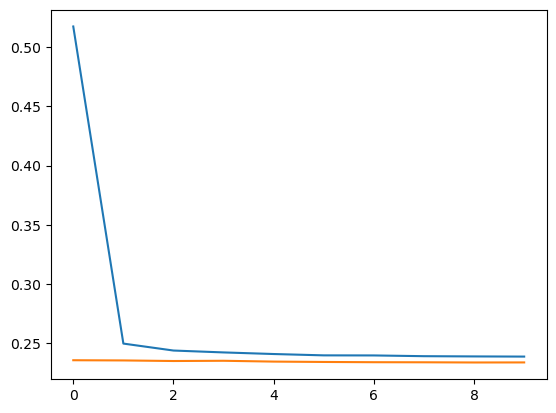

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [28]:


''

''